In [ ]:
import jax
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt

import stochastix as stx
from stochastix.utils.visualization import plot_abundance_dynamic

jax.config.update('jax_enable_x64', True)

key = rng.PRNGKey(10)

plt.rcParams['font.size'] = 18

## Chemical Oscillator Model

In [ ]:
# Define the oscillator reactions using the new API
reactions = [
    stx.Reaction('X0 + X1 -> 2 X1', stx.kinetics.MassAction(0.01)),
    stx.Reaction('X1 + X2 -> 2 X2', stx.kinetics.MassAction(0.01)),
    stx.Reaction('X0 + X2 -> 2 X0', stx.kinetics.MassAction(0.01)),
    stx.Reaction('2 X0 -> X0', stx.kinetics.MassAction(0.0001)),
    stx.Reaction('2 X1 -> X1', stx.kinetics.MassAction(0.0001)),
    stx.Reaction('2 X2 -> X2', stx.kinetics.MassAction(0.0001)),
]

oscillator = stx.ReactionNetwork(reactions)

In [3]:
print(oscillator)

R0:  X0 + X1 -> 2 X1  |  MassAction
R1:  X1 + X2 -> 2 X2  |  MassAction
R2:  X0 + X2 -> 2 X0  |  MassAction
R3:  2 X0 -> X0       |  MassAction
R4:  2 X1 -> X1       |  MassAction
R5:  2 X2 -> X2       |  MassAction


## Stochastic Simulation

In [ ]:
key, subkey = rng.split(key)

x0 = jnp.array([100, 50, 70])
T = 100

ssa_results = stx.stochsimsolve(
    subkey,
    oscillator,
    x0,
    T=T,
    max_steps=int(5e5),
)

print('Time overflow:\t', ssa_results.time_overflow)

Time overflow:	 False


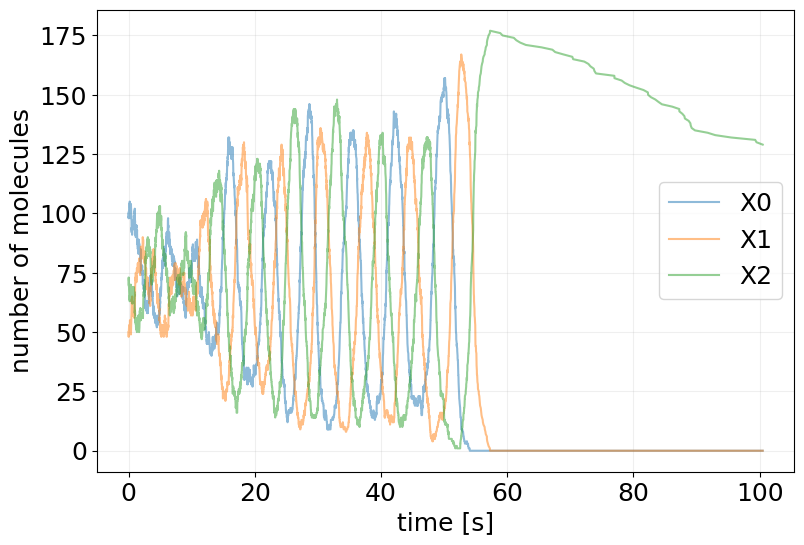

In [5]:
plot_abundance_dynamic(ssa_results);

## Conversion to ODE Model

In [6]:
from diffrax import Dopri5, ODETerm, SaveAt, diffeqsolve

In [ ]:
ode_term = ODETerm(oscillator.vector_field)
# or
# ode_term = oscillator.diffrax_ode_term()

dt0 = 0.1
saveat = SaveAt(ts=jnp.linspace(0.0, T, 1000))

ode_results = diffeqsolve(
    ode_term, Dopri5(), t0=0.0, t1=T, dt0=dt0, y0=x0, saveat=saveat, max_steps=int(1e6)
)

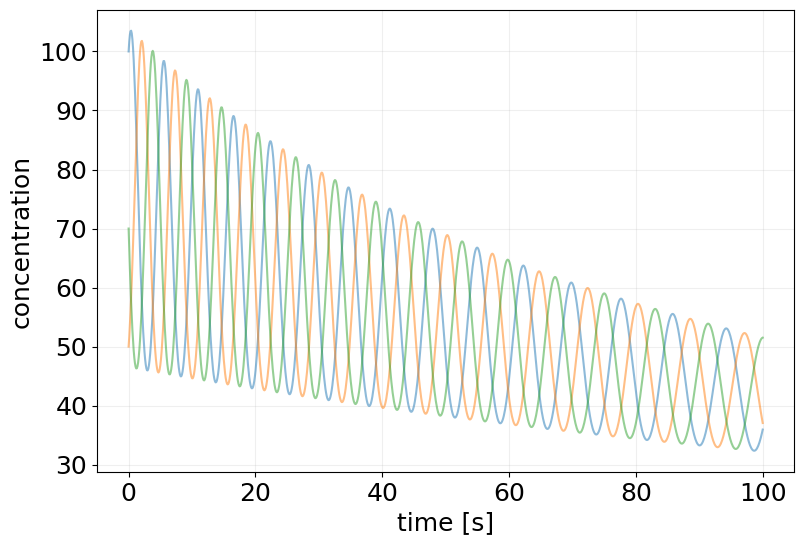

In [8]:
plt.figure(figsize=(9, 6))

plt.plot(ode_results.ts, ode_results.ys, alpha=0.5)
plt.xlabel('time [s]')
plt.ylabel('concentration')

plt.grid(alpha=0.2)

## Conversion to SDE Formulation

In [9]:
from diffrax import (
    ControlTerm,
    Euler,
    MultiTerm,
    ODETerm,
    SaveAt,
    VirtualBrownianTree,
    diffeqsolve,
)

In [10]:
t0, T = 0.0, 100

brownian_motion = VirtualBrownianTree(
    t0, T, tol=1e-1, shape=(oscillator.n_reactions,), key=subkey
)
terms = MultiTerm(
    ODETerm(oscillator.drift_fn), ControlTerm(oscillator.diffusion_fn, brownian_motion)
)

# or just:
# terms = oscillator.diffrax_sde_term(T, key=subkey)

solver = Euler()
saveat = SaveAt(steps=True)

dt0 = 0.1

sde_results = diffeqsolve(
    terms, solver, t0=t0, t1=T, dt0=dt0, y0=x0, saveat=saveat, max_steps=int(1e6)
)

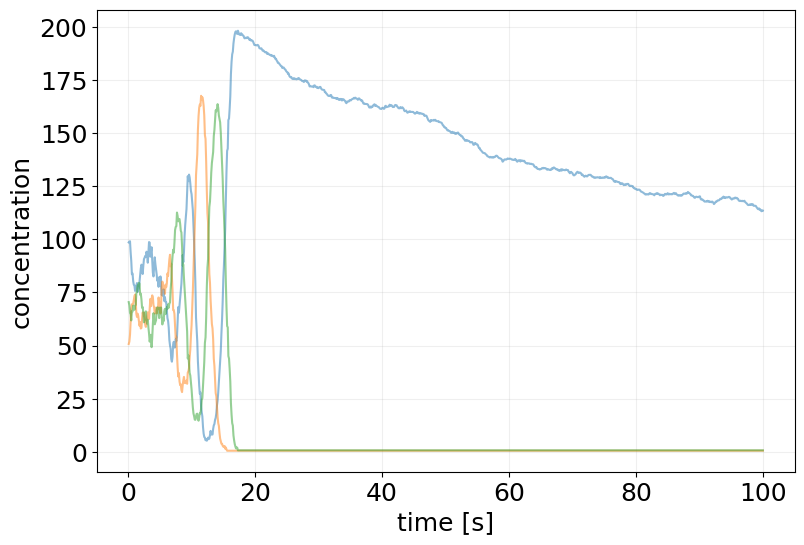

In [11]:
plt.figure(figsize=(9, 6))

plt.plot(sde_results.ts, sde_results.ys, alpha=0.5)
plt.xlabel('time [s]')
plt.ylabel('concentration')

# plt.yscale('log')

plt.grid(alpha=0.2)

# Lotka-Volterra Model (Predator-Prey)

In [ ]:
# Use the built-in Lotka-Volterra generator
lv_model = stx.generators.lotka_volterra_model(
    alpha=0.1,  # prey reproduction rate
    beta=0.005,  # predation rate
    gamma=0.05,  # predator death rate
)

In [13]:
print(lv_model)

R0 (prey_reproduction):  prey -> 2 prey                 |  MassAction
R1 (predation):          predator + prey -> 2 predator  |  MassAction
R2 (predator_death):     predator -> 0                  |  MassAction


## Stochastic Simulation

In [ ]:
key, subkey = rng.split(key)

x0 = jnp.array([30, 30])
T = 500

ssa_results = stx.stochsimsolve(
    subkey,
    lv_model,
    x0,
    T=T,
    max_steps=int(5e4),
)

print('Time overflow:\t', ssa_results.time_overflow)

Time overflow:	 False


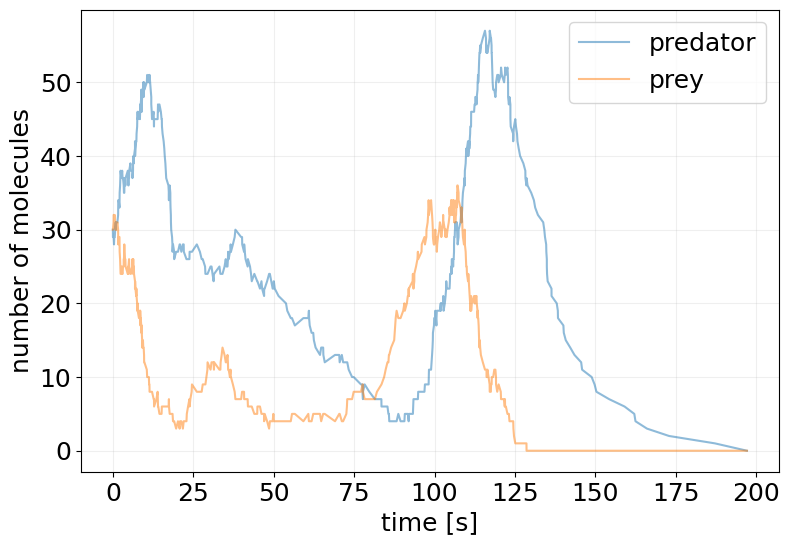

In [15]:
plot_abundance_dynamic(ssa_results, time_unit='s');

## Conversion to ODE Model

In [16]:
from diffrax import Dopri5, ODETerm, SaveAt, diffeqsolve

In [17]:
# ode_term = ODETerm(lv_model.vector_field)
ode_term = lv_model.diffrax_ode_term()

dt0 = 0.1
saveat = SaveAt(ts=jnp.linspace(0.0, T, 1000))

ode_results = diffeqsolve(
    ode_term, Dopri5(), t0=0.0, t1=T, dt0=dt0, y0=x0, saveat=saveat, max_steps=int(1e5)
)

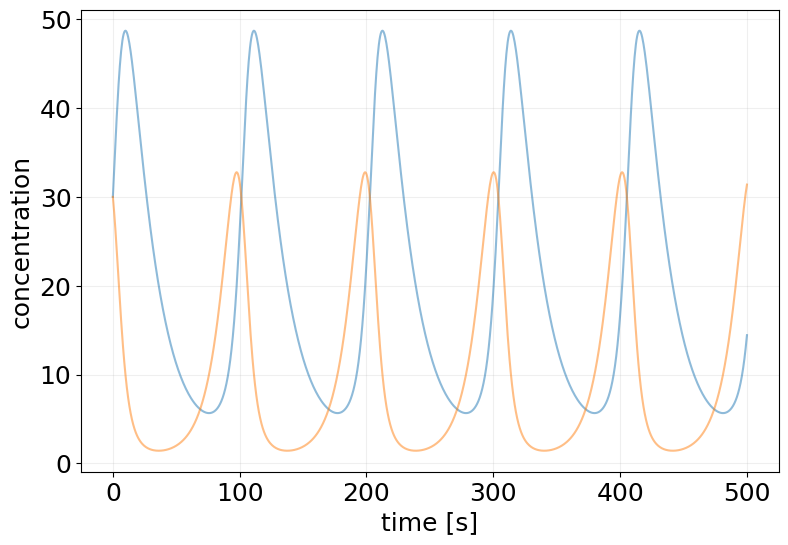

In [18]:
plt.figure(figsize=(9, 6))

plt.plot(ode_results.ts, ode_results.ys, alpha=0.5)
plt.xlabel('time [s]')
plt.ylabel('concentration')

plt.grid(alpha=0.2)

## Conversion to SDE Formulation

In [19]:
from diffrax import (
    ControlTerm,
    Euler,
    MultiTerm,
    ODETerm,
    SaveAt,
    VirtualBrownianTree,
    diffeqsolve,
)

In [ ]:
t0, T = 0.0, 500

# brownian_motion = VirtualBrownianTree(
#     t0, T, tol=1e-3, shape=(lv_model.n_reactions,), key=subkey
# )
# terms = MultiTerm(
#     ODETerm(lv_model.drift_fn), ControlTerm(lv_model.diffusion_fn, brownian_motion)
# )

terms = lv_model.diffrax_sde_term(T, key=subkey)

solver = Euler()
saveat = SaveAt(
    steps=True,
)

dt0 = 0.1

sde_results = diffeqsolve(
    terms, solver, t0=t0, t1=T, dt0=dt0, y0=x0, saveat=saveat, max_steps=int(1e5)
)

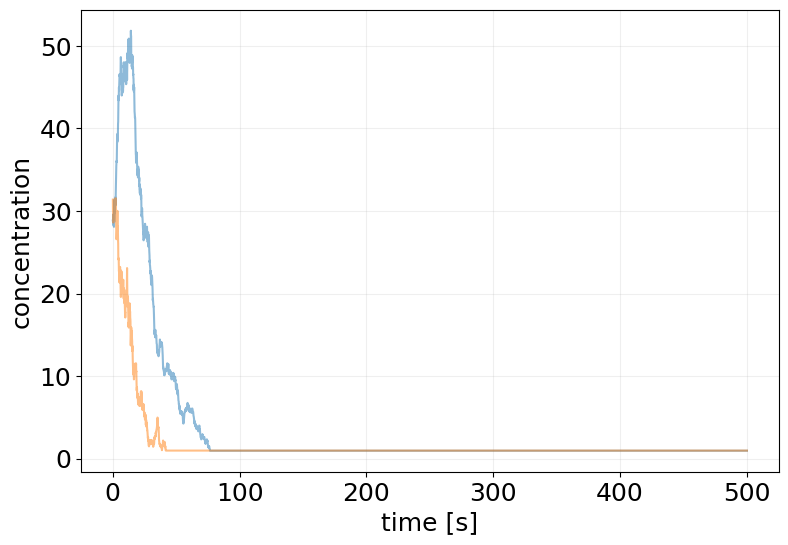

In [21]:
plt.figure(figsize=(9, 6))

plt.plot(sde_results.ts, sde_results.ys, alpha=0.5)
plt.xlabel('time [s]')
plt.ylabel('concentration')

# plt.yscale('log')

plt.grid(alpha=0.2)